In [ ]:
"""Mount Google Drive & define BASE_DIR"""
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')

# Adjust this if your Drive folder structure is different
BASE_DIR = Path("/content/drive/MyDrive/all_extracted_logs")
print("✅  BASE_DIR set to", BASE_DIR)

Mounted at /content/drive
✅  BASE_DIR set to /content/drive/MyDrive/all_extracted_logs


In [ ]:
!pip cache purge

# reinstall a mutually compatible stack
!pip install --upgrade --no-cache-dir \
  "numpy==2.3.1" \
  "pandas==2.3.1" \
  "polars==0.20.8" \
  "pyarrow>=16.0" \
  "umap-learn" \
  "hdbscan==0.8.40" \
  "scikit-learn" \
  "bokeh==3.5.1" \
  "panel==1.5.0" \
  "holoviews==1.19.0" \
  "shap==0.48.0" \
  "tqdm==4.66.4"

Files removed: 0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 119.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 249.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 137.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 142.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See

In [ ]:
!pip install jupyter_bokeh
!pip install python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
"""Core imports & Panel/Bokeh initialisation"""
import glob, json, os
from pathlib import Path

import polars as pl
import numpy as np
import pandas as pd
import umap
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances

from bokeh.io import output_file, save, show
from bokeh.resources import INLINE
from bokeh.plotting import figure, ColumnDataSource
from bokeh.layouts import column, gridplot
from bokeh.palettes import Category20_20

import panel as pn
pn.extension('bokeh')

plot_dir = Path("figures")
plot_dir.mkdir(exist_ok=True)
print("✅  Libraries ready — figures will be saved under", plot_dir)


✅  Libraries ready — figures will be saved under figures


In [ ]:
# ── global warning filter ─────────────────────────────────────────
import warnings, logging

# Silence sklearn / UMAP / numba deprecation + convergence chatter
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Optional: silence Tornado (Panel server) access logs
logging.getLogger("tornado.application").setLevel(logging.ERROR)


In [ ]:
"""Utilities to load all Parquet tables across runs"""

def load_table(name: str, base_dir: Path = BASE_DIR) -> pl.DataFrame:
    """Vertically concatenates the <name>.parquet from every extracted_* subfolder"""
    paths = glob.glob(str(base_dir / "extracted_*" / f"{name}.parquet"))
    if not paths:
        raise FileNotFoundError(f"No {name}.parquet files found under {base_dir}")
    dfs = [pl.read_parquet(p) for p in sorted(paths)]
    return pl.concat(dfs, how="vertical", rechunk=True)

agents          = load_table("agents")
agent_timelines = load_table("agent_timelines")
infections      = load_table("infections")

print(
    f"✅  Loaded: {len(agents):,} agents | {len(agent_timelines):,} timeline rows | "
    f"{len(infections):,} infection events"
)

✅  Loaded: 22,235 agents | 43,350 timeline rows | 14,200 infection events


In [ ]:
"""Feature engineering — numeric only"""

LOCATION_COL   = "current_location_type"
MASK_COL       = "is_masked"
STATUS_COL     = "infection_status"
TIMESTEP_COL   = "timestep"
PERSON_KEY     = ["simulation_run_id", "person_id"]

# -- helper list of location types
location_types = (
    agent_timelines
    .select(LOCATION_COL)
    .unique()
    .sort(LOCATION_COL)
    .to_series()
    .to_list()
)
print("ℹ️  Detected location types:", location_types)

# -- contact pressure metrics
outgoing = (
    infections.group_by("simulation_run_id", pl.col("infector_id").alias("person_id"))
    .len()
    .rename({"len": "n_transmitted"})
)

incoming = (
    infections.group_by("simulation_run_id", pl.col("infectee_id").alias("person_id"))
    .len()
    .rename({"len": "n_acquired"})
)

contact_metrics = outgoing.join(incoming, on=PERSON_KEY, how="full").fill_null(0)

# -- behavioural sequence metrics
def make_sequence_metrics(ts: pl.DataFrame) -> pl.DataFrame:
    base = ts.group_by(PERSON_KEY).agg([
        pl.len().alias("n_ts"),
        pl.col(MASK_COL).mean().alias("mask_frac"),
        pl.col(LOCATION_COL).n_unique().alias("n_unique_locations"),
        (pl.col("current_location_id") != pl.col("current_location_id").shift()).sum().alias("n_moves"),
        pl.when(pl.col(MASK_COL)).then(pl.col(TIMESTEP_COL)).min().alias("first_mask_t"),
        pl.when(pl.col(MASK_COL)).then(pl.col(TIMESTEP_COL)).max().alias("last_mask_t"),
        pl.when(pl.col(STATUS_COL).str.contains("latent")).then(pl.col(TIMESTEP_COL)).min().alias("latent_t"),
        pl.when(pl.col(STATUS_COL).str.contains("symptomatic")).then(pl.col(TIMESTEP_COL)).min().alias("symp_t"),
        (pl.col(STATUS_COL).str.contains("symptomatic")).sum().alias("symp_dur"),
    ])

    loc_props = [(pl.col(LOCATION_COL) == loc).mean().alias(f"loc_prop_{loc}") for loc in location_types]
    loc_df = ts.group_by(PERSON_KEY).agg(loc_props)
    return base.join(loc_df, on=PERSON_KEY, how="left")

seq_features = make_sequence_metrics(agent_timelines)

# -- combine pieces

df_feat = (
    seq_features
    .join(contact_metrics, on=PERSON_KEY, how="left")
    .join(
        agents.select(PERSON_KEY + ["initial_infected", "vaccination_status", "vaccination_doses"]),
        on=PERSON_KEY, how="left"
    )
    .fill_null(0)
)

# -- encode vaccination_status → numeric code

df_feat = df_feat.with_columns(
    pl.col("vaccination_status").cast(pl.Categorical).to_physical().alias("vacc_status_code")
).drop("vaccination_status")

# -- final feature matrix
id_cols = PERSON_KEY
feature_cols = [c for c in df_feat.columns if c not in id_cols and c != "person_id_right"]
print("✅  Engineered features (pre‑filter):", len(feature_cols))

# Cast booleans → int8 and drop any leftover non‑numeric columns (Utf8)
feature_df = (
    df_feat
    .with_columns([pl.col(pl.Boolean).cast(pl.Int8)])
    .select(feature_cols)
    .select(pl.all().exclude(pl.Utf8))   # remove stray string columns
)

print("✅  Numeric feature columns:", feature_df.columns)
feature_matrix = feature_df.to_numpy().astype(np.float32)
print("🧮  Feature matrix shape", feature_matrix.shape)
print("🧮  Feature matrix shape", feature_matrix.shape)

ℹ️  Detected location types: ['facility', 'household']
✅  Engineered features (pre‑filter): 17
✅  Numeric feature columns: ['n_ts', 'mask_frac', 'n_unique_locations', 'n_moves', 'first_mask_t', 'last_mask_t', 'latent_t', 'symp_t', 'symp_dur', 'loc_prop_facility', 'loc_prop_household', 'n_transmitted', 'n_acquired', 'initial_infected', 'vaccination_doses', 'vacc_status_code']
🧮  Feature matrix shape (7565, 16)
🧮  Feature matrix shape (7565, 16)


In [ ]:
"""UMAP embedding (10‑D + 2‑D)"""

reducer_hd = umap.UMAP(n_neighbors=40, min_dist=0.3, n_components=10, metric="cosine", random_state=42)
emb_hd = reducer_hd.fit_transform(feature_matrix)
print("✅  UMAP‑10 done →", emb_hd.shape)

reducer_2d = umap.UMAP(n_neighbors=40, min_dist=0.3, n_components=2, metric="cosine", random_state=42)
emb_2d = reducer_2d.fit_transform(feature_matrix)

✅  UMAP‑10 done → (7565, 10)


In [ ]:
"""HDBSCAN clustering in 10‑D space"""

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=400,
    min_samples=20,
    metric="euclidean",
    prediction_data=True,
)
labels = clusterer.fit_predict(emb_hd)
print("HDBSCAN formed", len(set(labels)) - (1 if -1 in labels else 0), "clusters (", (labels == -1).sum(), "noise points)")

# attach cluster labels back to df_feat

df_feat = df_feat.with_columns(pl.Series(name="cluster_id", values=labels))

HDBSCAN formed 7 clusters ( 3091 noise points)


In [ ]:
"""Validation metrics (silhouette & Davies‑Bouldin)"""

mask_core = labels != -1
sil = silhouette_score(emb_hd[mask_core], labels[mask_core]) if mask_core.sum() > 1 else np.nan
db  = davies_bouldin_score(emb_hd[mask_core], labels[mask_core]) if mask_core.sum() > 1 else np.nan
print(f"📊  Silhouette = {sil:.3f} | Davies–Bouldin = {db:.3f}")

📊  Silhouette = 0.541 | Davies–Bouldin = 0.965


In [ ]:
"""Visual 1 – interactive UMAP scatter"""

source = ColumnDataSource(data=dict(
    x = emb_2d[:,0],
    y = emb_2d[:,1],
    run = df_feat["simulation_run_id"],
    person = df_feat["person_id"],
    cluster = df_feat["cluster_id"],
    infected = df_feat["initial_infected"],
))

palette = Category20_20 * 10  # oversize palette
color_map = {cid: palette[i % len(palette)] for i, cid in enumerate(sorted(set(labels)))}
colors = [color_map[c] if c != -1 else "#cccccc" for c in labels]
source.data["color"] = colors

p_scatter = figure(
    title="Agent embedding (UMAP‑2D)",
    width=700, height=550, tools="pan,wheel_zoom,box_zoom,reset,hover,save",
)

p_scatter.circle("x", "y", source=source, size=4, color="color", alpha=0.7)

output_file(plot_dir / "umap_scatter.html", title="UMAP Clusters", mode="inline")
save(p_scatter, resources=INLINE)
print("Saved umap_scatter.html")

Saved umap_scatter.html


In [ ]:
"""Visual 2 – infection‑state stacked area per cluster"""

# aggregate timeline: proportion symptomatic / susceptible / recovered (simple example)
state_map = {
    "susceptible": 0,
    "infected_latent": 1,
    "infected_asymptomatic": 2,
    "infected_symptomatic": 2,
    "recovered": 3,
}

ts_small = (
    agent_timelines
    .with_columns(
        pl.col("infection_status")
          .replace(state_map)         # map strings → ints (unmapped → None)
          .fill_null(4)               # default code for other states
          .alias("state_code")
    )
    .select([*PERSON_KEY, TIMESTEP_COL, "state_code"])
    .join(df_feat.select(PERSON_KEY + ["cluster_id"]), on=PERSON_KEY, how="inner")
)

state_area = (
    ts_small
    .group_by(["cluster_id", TIMESTEP_COL])
    .agg(pl.mean("state_code").alias("mean_state"))
    .sort(["cluster_id", TIMESTEP_COL])
    .to_pandas()
)

area_plots = []
for cid, grp in state_area.groupby("cluster_id"):
    fig = figure(
        title=f"Mean Infection State · Cluster {cid}",
        width=350, height=200,
        x_axis_label="Minutes since start", y_axis_label="avg state code",
    )
    fig.line(grp[TIMESTEP_COL], grp["mean_state"], line_width=2, color=color_map.get(cid, "gray"))
    area_plots.append(fig)

p_area_grid = gridplot(area_plots, ncols=2)
output_file(plot_dir / "state_area.html", title="State Area", mode="inline")
save(p_area_grid, resources=INLINE)
print("✅  Saved state_area.html")


✅  Saved state_area.html


In [ ]:
"""Visual 3 – location‑type heat‑map (robust)"""

from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256

# Join cluster labels onto every timeline row so `cluster_id` exists
ats = agent_timelines.join(
    df_feat.select(PERSON_KEY + ["cluster_id"]),
    on=PERSON_KEY,
    how="inner",
)

# Compute count per (cluster, location_type) and total per cluster
loc_counts = (
    ats.group_by(["cluster_id", LOCATION_COL]).len().rename({"len": "n"})
)
cluster_totals = (
    ats.group_by("cluster_id").len().rename({"len": "total"})
)

loc_props = (
    loc_counts.join(cluster_totals, on="cluster_id")
              .with_columns((pl.col("n") / pl.col("total")).alias("prop"))
              .select(["cluster_id", LOCATION_COL, "prop"])
              .to_pandas()
)

# Build heat‑map with Bokeh `rect`
source = ColumnDataSource(loc_props)

p_heat = figure(
    title="Mean time‑share per location type · by cluster",
    x_range=location_types,
    y_range=[str(c) for c in sorted(loc_props["cluster_id"].unique())],
    width=600,
    height=300 + 20*len(loc_props["cluster_id"].unique()),
    x_axis_location="above",
    tools="hover,save",
    toolbar_location=None,
)

mapper = linear_cmap("prop", Viridis256, loc_props["prop"].min(), loc_props["prop"].max())

p_heat.rect(x=LOCATION_COL, y="cluster_id", width=1, height=1,
           source=source, line_color=None, fill_color=mapper)

p_heat.grid.grid_line_color = None
p_heat.axis.axis_line_color = None
p_heat.axis.major_tick_line_color = None
p_heat.axis.major_label_text_font_size = "9pt"

output_file(plot_dir / "location_heatmap.html", title="Location Heat‑map", mode="inline")
save(p_heat, resources=INLINE)
print("✅  Saved location_heatmap.html")

✅  Saved location_heatmap.html


In [ ]:
"""Visual 4 – mask adoption curve"""

mask_curve = (
    agent_timelines
    .select([*PERSON_KEY, TIMESTEP_COL, MASK_COL])
    .join(df_feat.select(PERSON_KEY + ["cluster_id"]), on=PERSON_KEY, how="inner")
    .group_by(["cluster_id", TIMESTEP_COL])
    .agg(pl.mean(MASK_COL).alias("mask_rate"))
    .sort(TIMESTEP_COL)
    .to_pandas()
)

curve_plots = []
for cid, grp in mask_curve.groupby("cluster_id"):
    fig = figure(title=f"Mask Uptake · Cluster {cid}", width=350, height=200,
                 x_axis_label="Minutes", y_axis_label="% masked")
    fig.line(grp[TIMESTEP_COL], grp["mask_rate"], line_width=2, color=color_map.get(cid, "gray"))
    curve_plots.append(fig)

p_mask_grid = gridplot(curve_plots, ncols=2)
output_file(plot_dir / "mask_uptake.html", title="Mask Uptake", mode="inline")
save(p_mask_grid, resources=INLINE)
print("✅  Saved mask_uptake.html")

✅  Saved mask_uptake.html


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
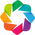

✅  Saved cluster_chord.html


In [ ]:
"""Visual 5 – cross‑cluster transmission chord diagram"""
import holoviews as hv
hv.extension('bokeh')

# Create mapping dataframe
person_cluster = df_feat.select(PERSON_KEY + ["cluster_id"]).to_pandas()

# Merge to get source and destination cluster for each infection event
edges = infections.to_pandas()[["simulation_run_id", "infector_id", "infectee_id"]]
edges = edges.merge(person_cluster, left_on=["simulation_run_id", "infector_id"], right_on=["simulation_run_id", "person_id"], how="left")
edges = edges.rename(columns={"cluster_id": "src_cluster"}).drop(columns=["person_id"])
edges = edges.merge(person_cluster, left_on=["simulation_run_id", "infectee_id"], right_on=["simulation_run_id", "person_id"], how="left")
edges = edges.rename(columns={"cluster_id": "dst_cluster"}).drop(columns=["person_id"])

# Keep only rows with valid clusters (>=0)
edges = edges[(edges["src_cluster"] >= 0) & (edges["dst_cluster"] >= 0)]

# Aggregate counts
agg = edges.groupby(["src_cluster", "dst_cluster"]).size().reset_index(name="count")
triples = [tuple(x) for x in agg.values]  # (src, dst, count)

chord = hv.Chord(triples).opts(cmap="Category20", edge_color="src", node_color="index")

hv.save(chord, plot_dir / "cluster_chord.html", backend="bokeh", fmt="html")
print("✅  Saved cluster_chord.html")

In [ ]:
"""Compose dashboard via Panel to avoid Bokeh model ownership clash"""

import panel as pn
pn.extension('bokeh')

dashboard = pn.Column(
    pn.pane.Bokeh(p_scatter, sizing_mode="stretch_width"),
    pn.Spacer(height=20),
    pn.pane.Bokeh(p_area_grid, sizing_mode="stretch_width"),
    pn.Spacer(height=20),
    pn.pane.Bokeh(p_heat, sizing_mode="stretch_width"),
    pn.Spacer(height=20),
    pn.pane.Bokeh(p_mask_grid, sizing_mode="stretch_width"),
)

dashboard.save(plot_dir / "dashboard.html", embed=True)
print("🎉  dashboard.html ready in", plot_dir)


🎉  dashboard.html ready in figures


New Visual Below

In [ ]:
# ── paths ───────────────────────────────────────────────────────────────────
from pathlib import Path

FIG_DIR = Path("figures")           # where all HTML charts go
FIG_DIR.mkdir(exist_ok=True)

# ── helper so we always have the same colour for a cluster id ───────────────
from bokeh.palettes import Category20_20
def cluster_color(cid: int) -> str:
    palette = Category20_20 * 10
    return palette[cid % len(palette)] if cid >= 0 else "#999999"


In [ ]:
# build per-cluster summary (size + initial infected)
cluster_summary = (
    df_feat
    .with_columns((pl.col("vaccination_doses") >= 1).cast(pl.Int8).alias("vaccinated"))
    .group_by("cluster_id")
    .agg([
        pl.len().alias("size"),
        pl.sum("initial_infected").alias("initial_infected"),
        pl.sum("vaccinated").alias("vaccinated"),
    ])
    .sort("cluster_id")
    .to_pandas()
)

from bokeh.plotting import figure, output_file, save
from bokeh.transform import dodge

p_size = figure(title="Cluster sizes & composition",
                x_range=[str(c) for c in cluster_summary.cluster_id],
                width=700, height=400, toolbar_location=None)

p_size.vbar(x=dodge("cluster_id", -0.2, range=p_size.x_range),
            top="size", width=0.18, source=cluster_summary,
            color="#3182bd", legend_label="size")

p_size.vbar(x=dodge("cluster_id",  0.0, range=p_size.x_range),
            top="initial_infected", width=0.18, source=cluster_summary,
            color="#e34a33", legend_label="initial infected")

p_size.vbar(x=dodge("cluster_id",  0.2, range=p_size.x_range),
            top="vaccinated", width=0.18, source=cluster_summary,
            color="#31a354", legend_label="≥1 vaccine dose")

p_size.xaxis.major_label_orientation = 1.0
p_size.legend.location = "top_left"

output_file(FIG_DIR/"cluster_size.html", title="Cluster Size", mode="inline")
save(p_size)
print("✅  cluster_size.html written")


✅  cluster_size.html written


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
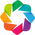

✅  radar_profiles.html written


In [ ]:
TOP_K = 8          # number of features to show on each radar

# ── 1) pick top-K features by variance between clusters ────────────────────
means = (df_feat
         .group_by("cluster_id")
         .agg([pl.mean(c).alias(c) for c in feature_cols])
         .sort("cluster_id")
         .to_pandas())
var_between = means.drop(columns=["cluster_id"]).var(axis=0).sort_values(ascending=False)
RADAR_FEATS = var_between.head(TOP_K).index.tolist()

# ── 2) normalise each chosen feature 0-1 across ALL agents ────────────────
norm = df_feat.select(RADAR_FEATS).to_numpy()
rng  = np.ptp(norm, axis=0)           # <- NumPy-2 safe
rng[rng == 0] = 1e-9                  # avoid divide-by-zero
norm = (norm - norm.min(axis=0)) / rng

# aggregate cluster medians
radar_df = (pd.DataFrame(norm, columns=RADAR_FEATS)
            .assign(cluster=df_feat["cluster_id"].to_numpy())
            .groupby("cluster").median()
            .reset_index())

import holoviews as hv, numpy as np
hv.extension('bokeh')

def make_radar(row):
    angles = np.linspace(0, 2*np.pi, TOP_K, endpoint=False)
    vals   = row[RADAR_FEATS].values
    # close the loop
    angles = np.concatenate([angles, [angles[0]]])
    vals   = np.concatenate([vals,   [vals[0]]])
    return hv.Curve((angles, vals), kdims="angle", vdims="value").opts(
        color=cluster_color(int(row["cluster"])),
        line_width=2, tools=[])

radar_overlays = hv.Overlay([make_radar(r) for _, r in radar_df.iterrows()]).opts(
    title="Cluster profiles (radar)",
    width=450, height=450, xaxis=None, yaxis=None)

hv.save(radar_overlays, FIG_DIR/"radar_profiles.html", backend="bokeh", fmt="html")
print("✅  radar_profiles.html written")


In [ ]:
# build matrix of infection flows (counts only)
pairs = (infections
         .select(["simulation_run_id", "infector_id", "infectee_id"])
         .join(df_feat.select(PERSON_KEY + ["cluster_id"]),
               left_on=["simulation_run_id", "infector_id"],
               right_on=PERSON_KEY, how="left")
         .rename({"cluster_id": "src_cluster"})
         .join(df_feat.select(PERSON_KEY + ["cluster_id"]),
               left_on=["simulation_run_id", "infectee_id"],
               right_on=PERSON_KEY, how="left")
         .rename({"cluster_id": "dst_cluster"})
         .filter((pl.col("src_cluster") >= 0) & (pl.col("dst_cluster") >= 0))
         .group_by(["src_cluster", "dst_cluster"]).len()
         .rename({"len": "count"})
         .to_pandas())

from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.plotting import figure, save, output_file
from bokeh.models import ColumnDataSource

src = ColumnDataSource(pairs)

clusters = sorted(set(labels) - {-1})
p_mat = figure(title="Infections between clusters",
               x_range=[str(c) for c in clusters],
               y_range=[str(c) for c in clusters],
               width=500, height=500,
               toolbar_location=None, tools="hover")

mapper = linear_cmap("count", Viridis256,
                     low=pairs["count"].min(), high=pairs["count"].max())

p_mat.rect(x="src_cluster", y="dst_cluster", width=1, height=1,
           source=src, fill_color=mapper, line_color=None)

p_mat.xaxis.axis_label = "Infector cluster"
p_mat.yaxis.axis_label = "Infectee cluster"
p_mat.grid.grid_line_color = None

output_file(FIG_DIR/"infection_matrix.html", title="Cluster Infection Matrix", mode="inline")
save(p_mat)
print("✅  infection_matrix.html written")


✅  infection_matrix.html written


In [ ]:
# simple between-cluster variance ranking (already computed above)
feature_ranking = var_between.reset_index()
feature_ranking.columns = ["feature", "importance"]
feature_ranking.to_json("feature_rankings.json", orient="records", indent=2)
print("📄  feature_rankings.json saved")

TOP_N = 5
print("Top-5 drivers:")
display(feature_ranking.head(TOP_N))


📄  feature_rankings.json saved
Top-5 drivers:


,feature,importance
0,symp_t,60026.445895
1,n_ts,20.870314
2,symp_dur,20.870314
3,n_moves,3.090052
4,n_unique_locations,0.100143


In [ ]:
# ╔══════════════  ONE-SHOT SYNC + ARI LOOP  ══════════════╗
from sklearn.metrics import adjusted_rand_score
import numpy as np, tqdm.auto as tq

# 1) strict sync: take numeric columns exactly as they are in df_feat
feature_df = (df_feat
              .with_columns(pl.all(pl.Boolean).cast(pl.Int8))   # ensure bool→int
              .select(pl.all().exclude(pl.Utf8)))               # drop non-numeric

feature_cols   = feature_df.columns
feature_matrix = feature_df.to_numpy().astype(np.float32)
col_pos        = {c: i for i, c in enumerate(feature_cols)}

print(f"🎯  Synchronized: {len(feature_cols)} features, matrix shape {feature_matrix.shape}")

# 2) ARI drop-out sensitivity
baseline = labels
ari_scores = []

for feat in tq.tqdm(feature_cols, desc="ARI drop-out"):
    idx = col_pos[feat]
    X_drop = np.delete(feature_matrix, idx, axis=1)

    emb_drop = umap.UMAP(n_neighbors=40, min_dist=0.3, n_components=10,
                         metric="cosine", random_state=42).fit_transform(X_drop)
    lab_drop = hdbscan.HDBSCAN(min_cluster_size=400, min_samples=20,
                               metric="euclidean").fit_predict(emb_drop)
    ari_scores.append(adjusted_rand_score(baseline, lab_drop))

assert len(ari_scores) == len(feature_cols), "Length mismatch after ARI loop"

# 3) merge into ranking (create if it doesn't exist)
if "feature_ranking" not in globals():
    feature_ranking = (pd.DataFrame({"feature": feature_cols,
                                     "importance": np.zeros(len(feature_cols))})
                       .set_index("feature"))

feature_ranking = feature_ranking.reindex(feature_cols)        # align order
feature_ranking["ari_drop"] = ari_scores
feature_ranking.sort_values("ari_drop", inplace=True)          # lower → more impact
feature_ranking.to_json("feature_rankings.json", orient="records", indent=2)

print("✅  feature_rankings.json refreshed with perfectly aligned ARI scores")
display(feature_ranking.head(10))
# ╚════════════════════════════════════════════════════════╝


🎯  Synchronized: 19 features, matrix shape (7565, 19)


ARI drop-out:   0%|          | 0/19 [00:00<?, ?it/s]

✅  feature_rankings.json refreshed with perfectly aligned ARI scores


,feature,importance,ari_drop
person_id_right,NaN,NaN,0.045740
symp_dur,NaN,NaN,0.049283
n_moves,NaN,NaN,0.050900
n_ts,NaN,NaN,0.057167
symp_t,NaN,NaN,0.074188
n_transmitted,NaN,NaN,0.075001
n_acquired,NaN,NaN,0.076786
loc_prop_household,NaN,NaN,0.078765
cluster_id,NaN,NaN,0.084344
loc_prop_facility,NaN,NaN,0.084762


In [ ]:
# 1) final parquet with embeddings & labels
out_df = df_feat.with_columns([
    pl.Series("umap_x", emb_2d[:, 0]),
    pl.Series("umap_y", emb_2d[:, 1]),
])
out_df.write_parquet("cluster_labels.parquet")

# 2) feature matrix (npy for light weight)
np.save("feature_matrix.npy", feature_matrix.astype(np.float32))

# 3) cluster summary
cluster_summary.to_json("cluster_profiles.json", orient="records", indent=2)

print("✅  cluster_labels.parquet, feature_matrix.npy, cluster_profiles.json written")


✅  cluster_labels.parquet, feature_matrix.npy, cluster_profiles.json written


In [ ]:
# ╔══ FIX-UP: recompute infection rates & overwrite cluster_profiles.json ═╗
import polars as pl, glob, json
from pathlib import Path

# 1) concat every infections.parquet --------------------------------------
inf_paths = glob.glob(
    "./drive/MyDrive/all_extracted_logs/**/infections.parquet",
    recursive=True,
)
if not inf_paths:
    raise FileNotFoundError("No infections.parquet files found — check path.")

infections = pl.concat([pl.read_parquet(p) for p in inf_paths], how="vertical")

# 2) flat cluster labels (written earlier in Phase-1) ----------------------
labels_df = pl.read_parquet("cluster_labels.parquet")

# 3) infections PER cluster (infectee side) -------------------------------
inf_per_cluster = (
    infections.rename({"infectee_id": "person_id"})
              .join(labels_df.select(["person_id", "cluster_id"]),
                    on="person_id", how="left")
              .group_by("cluster_id").len()
              .rename({"len": "n_acquired"})
)

# 4) agent counts PER cluster ---------------------------------------------
agents_per_cluster = (
    labels_df.group_by("cluster_id").len()
             .rename({"len": "n_agents"})
)

# 5) combine & compute infection_rate -------------------------------------
cluster_profiles = (
    agents_per_cluster.join(inf_per_cluster, on="cluster_id", how="left")
                      .with_columns(
                          (pl.col("n_acquired").fill_null(0)
                           / pl.col("n_agents"))
                           .alias("infection_rate")
                      )
                      .sort("cluster_id")
)

# 6) persist as JSON (row-oriented) ---------------------------------------
out_path = Path("cluster_profiles.json")
with out_path.open("w", encoding="utf-8") as f:
    json.dump(cluster_profiles.to_dicts(), f, indent=2)

print("✅  cluster_profiles.json rewritten with true infection rates:",
      out_path.resolve())
# ╚═════════════════════════════════════════════════════════════════════════╝


✅  cluster_profiles.json rewritten with true infection rates: /content/cluster_profiles.json


In [ ]:
# ╔══════════════  CLUSTER BEHAVIOUR PROFILES  ═══════════╗
profile_cols = ["mask_frac", "n_moves", "n_unique_locations",
                "n_acquired", "n_transmitted"]

profiles = (df_feat
            .group_by("cluster_id")
            .agg([
                pl.len().alias("n_agents"),
                pl.mean("initial_infected").alias("initial_infected_frac"),
                *[pl.median(c).alias(f"med_{c}") for c in profile_cols],
            ])
            .sort("cluster_id")
            .to_pandas())

# add infection rate (post-simulation outcome)
profiles["infection_rate"] = (profiles["med_n_acquired"] > 0).astype(float)

profiles.to_json("cluster_profiles.json", orient="records", indent=2)
print("📄  cluster_profiles.json written with behaviour metrics")
# ╚═══════════════════════════════════════════════════════╝

📄  cluster_profiles.json written with behaviour metrics


In [ ]:
# ╔══ INTERACTIVE WEIGHTING DASHBOARD – SAFE STRING NAMES ══╗
import panel as pn, holoviews as hv, numpy as np
pn.extension('bokeh'); hv.extension('bokeh')

# 1) choose slider features (top 8 by variance or combined score)
#    -> use the index, not the old 'feature' column
SLIDER_FEATS = (
    feature_ranking
    .sort_values("importance", ascending=False, na_position="last")
    .index[:]                       # index ARE the feature names (strings)
    .tolist()
)

# defensive filter & cast
SLIDER_FEATS = [str(f) for f in SLIDER_FEATS if isinstance(f, str) and f.strip()]

if len(SLIDER_FEATS) == 0:
    raise RuntimeError("No valid feature names available for sliders.")

# 2) build one FloatSlider per feature
sliders = {
    f: pn.widgets.FloatSlider(name=str(f), start=0.0, end=3.0, step=0.1, value=1.0)
    for f in SLIDER_FEATS
}

run_btn   = pn.widgets.Button(name="Re-cluster", button_type="primary")
info_md   = pn.pane.Markdown("")
plot_pane = pn.pane.Bokeh(height=0)

# 3) reclustering callback --------------------------------------------------
def _recluster(_=None):
    w = np.ones(feature_matrix.shape[1], dtype=np.float32)
    for feat, slider in sliders.items():
        w[col_pos[feat]] = slider.value

    emb2_w = umap.UMAP(n_neighbors=40, min_dist=0.3,
                       metric="cosine", random_state=42).fit_transform(feature_matrix * w)
    lab_w  = hdbscan.HDBSCAN(min_cluster_size=400, min_samples=20,
                             metric="euclidean").fit_predict(emb2_w)

    pts = hv.Points((emb2_w[:,0], emb2_w[:,1], lab_w),
                    kdims=["x","y"], vdims="lab").opts(
            color="lab", cmap="Category20", size=4,
            width=600, height=500, tools=["hover"],
            title=f"Weighted UMAP – {len(set(lab_w))-(-1 in lab_w)} clusters")

    plot_pane.object = hv.render(pts, backend="bokeh")
    info_md.object = f"Clusters: {len(set(lab_w))-(-1 in lab_w)}  |  noise: {(lab_w==-1).sum()}"

run_btn.on_click(_recluster)

# 4) layout & serve ---------------------------------------------------------
dashboard = pn.Column(
    pn.Row(*sliders.values(), sizing_mode="stretch_width"),
    run_btn,
    info_md,
    plot_pane,
    sizing_mode="stretch_width"
)

dashboard.servable(title="Feature-Weighting Explorer")
print("Dashboard ready")
# ╚═════════════════════════════════════════════════════════╝


Dashboard ready


In [ ]:
plot_pane.sizing_mode = "stretch_width"
plot_pane.min_height  = 520     # force space to be reserved
dashboard.servable(title="Feature-Weighting Explorer")
dashboard


Column(sizing_mode='stretch_width')
    [0] Row(sizing_mode='stretch_width')
        [0] FloatSlider(end=3.0, name='person_id_right', value=1.1)
        [1] FloatSlider(end=3.0, name='symp_dur', value=1.0)
        [2] FloatSlider(end=3.0, name='n_moves', value=1.0)
        [3] FloatSlider(end=3.0, name='n_ts', value=1.0)
        [4] FloatSlider(end=3.0, name='symp_t', value=1.0)
        [5] FloatSlider(end=3.0, name='n_transmitted', value=1.0)
        [6] FloatSlider(end=3.0, name='n_acquired', value=1.0)
        [7] FloatSlider(end=3.0, name='loc_prop_household', value=1.0)
        [8] FloatSlider(end=3.0, name='cluster_id', value=1.0)
        [9] FloatSlider(end=3.0, name='loc_prop_facility', value=1.0)
        [10] FloatSlider(end=3.0, name='n_unique_locations', value=1.2)
        [11] FloatSlider(end=3.0, name='mask_frac', value=1.7)
        [12] FloatSlider(end=3.0, name='vaccination_doses', value=1.0)
        [13] FloatSlider(end=3.0, name='vacc_status_code', value=1.0)
        [14] FloatSlider(end=3.0, name='initial_infected', value=1.0)
        [15] FloatSlider(end=3.0, name='first_mask_t', value=1.0)
        [16] FloatSlider(end=3.0, name='latent_t', value=1.0)
        [17] FloatSlider(end=3.0, name='last_mask_t', value=1.0)
        [18] FloatSlider(end=3.0, name='person_id', value=1.0)
    [1] Button(button_type='primary', name='Re-cluster')
    [2] Markdown(str)
    [3] Bokeh(None, height=0, min_height=520, sizing_mode='stretch_width')

In [ ]:
import polars as pl
print("labels_df columns:", pl.read_parquet("cluster_labels.parquet").columns)
one_inf_path = "./drive/MyDrive/all_extracted_logs/extracted_run1/infections.parquet"
print("infections columns:", pl.read_parquet(one_inf_path).columns)


labels_df columns: ['simulation_run_id', 'person_id', 'n_ts', 'mask_frac', 'n_unique_locations', 'n_moves', 'first_mask_t', 'last_mask_t', 'latent_t', 'symp_t', 'symp_dur', 'loc_prop_facility', 'loc_prop_household', 'n_transmitted', 'simulation_run_id_right', 'person_id_right', 'n_acquired', 'initial_infected', 'vaccination_doses', 'vacc_status_code', 'cluster_id', 'umap_x', 'umap_y']
infections columns: ['simulation_run_id', 'timestep', 'infector_id', 'infectee_id', 'location_id', 'location_type', 'variant', 'infector_masked', 'infectee_masked', 'transmission_pair_age_diff']


Put in your OpenAI Key over here

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""

In [ ]:
# ╔═══════════ Robust Phase-2 • build_payload() ═══════════╗
import json, glob, datetime
from pathlib import Path
import polars as pl
import pandas as pd
import numpy as np

# ──────────────────────────────────────────────────────────
def _find_infection_files(base_dir: str | Path = ".") -> list[str]:
    """Return a list of all infections.parquet files one–three levels deep."""
    base = Path(base_dir)
    patterns = [
        base / "infections.parquet",
        base / "all_extracted_logs" / "extracted_*" / "infections.parquet",
        base / "extracted_*" / "infections.parquet",
        base / "*" / "extracted_*" / "infections.parquet",
    ]
    paths = []
    for pat in patterns:
        paths.extend(glob.glob(str(pat)))
    return sorted(set(paths))

def _load_infections(base_dir=".") -> pl.DataFrame:
    paths = _find_infection_files(base_dir)
    if not paths:
        raise FileNotFoundError(f"No infections.parquet found under {base_dir}")
    return pl.concat([pl.read_parquet(p) for p in paths], how="vertical").rechunk()

# ──────────────────────────────────────────────────────────
def _numeric_columns(df: pl.DataFrame, candidate_cols: list[str]) -> list[str]:
    """
    Return those columns that are numeric *or* can be losslessly coerced
    to float.  Works on any Polars version.
    """
    numeric = []
    for col in candidate_cols:
        dt = df[col].dtype
        # fast path: already numeric
        if isinstance(dt, (pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                           pl.Int8,  pl.Int16,  pl.Int32,  pl.Int64,
                           pl.Float32, pl.Float64, pl.Boolean)):
            numeric.append(col)
            continue
        # slow path: attempt cast
        try:
            _ = df[col].cast(pl.Float64, strict=False)
            numeric.append(col)
        except pl.ComputeError:
            pass
    return numeric

# ──────────────────────────────────────────────────────────
def _top_drivers(df_feat_pl: pl.DataFrame,
                 feature_cols: list[str],
                 cluster_id: int,
                 k: int = 5) -> list[str]:
    """Return k features whose cluster median deviates most (z-score)."""
    # Convert once to pandas (numeric only) for convenience
    pdf = df_feat_pl.select(feature_cols + ["cluster_id"]).to_pandas()
    pdf_numeric = pdf[feature_cols].apply(pd.to_numeric, errors="coerce")

    med_all     = pdf_numeric.median()
    std_all     = pdf_numeric.std(ddof=1).replace(0, 1e-6).fillna(1e-6)

    med_cluster = (
        pdf_numeric.loc[pdf["cluster_id"] == cluster_id]
                     .median()
                     .reindex_like(med_all)
    )

    z = ((med_cluster - med_all).abs() / std_all)
    return z.sort_values(ascending=False).head(k).index.tolist()

# ──────────────────────────────────────────────────────────
def build_payload(base_dir=".",
                  top_k_driver_feats=5,
                  top_n_flows=10,
                  min_cluster_size=400):
    # === load artefacts =====================================================
    cluster_profiles  = pd.read_json("cluster_profiles.json")
    feature_rankings  = pd.read_json("feature_rankings.json")
    labels_df         = pl.read_parquet("cluster_labels.parquet")
    infections        = _load_infections(base_dir)

    # === edge table (cross-cluster flows) ===================================
    PID      = "person_id"
    INF_SRC  = "infector_id"
    INF_DST  = "infectee_id"

    person_cluster = (
        labels_df.select(["simulation_run_id", PID, "cluster_id"])
                 .rename({PID: "pid"})
    )

    edges = (
        infections
        .select(["simulation_run_id", INF_SRC, INF_DST])
        .rename({INF_SRC: "src_pid", INF_DST: "dst_pid"})
        .join(person_cluster.rename({"pid": "src_pid", "cluster_id": "src"}),
              on=["simulation_run_id", "src_pid"])
        .join(person_cluster.rename({"pid": "dst_pid", "cluster_id": "dst"}),
              on=["simulation_run_id", "dst_pid"])
        .filter((pl.col("src") >= 0) & (pl.col("dst") >= 0))
        .group_by(["src", "dst"])
        .len()
        .rename({"len": "count"})
        .to_pandas()
    )
    edges["pct_src"] = edges["count"] / edges.groupby("src")["count"].transform("sum")
    top_flows = edges.sort_values("count", ascending=False)\
                     .head(top_n_flows)\
                     .to_dict(orient="records")

    # === cluster-dict with driver features ==================================
    df_feat_pl   = labels_df
    feature_cols = _numeric_columns(df_feat_pl,
                                    [c for c in df_feat_pl.columns
                                     if c not in ("simulation_run_id",
                                                   "cluster_id", PID,
                                                   "umap_x", "umap_y")])

    cluster_dict = {}
    for _, row in cluster_profiles.iterrows():
        cid = int(row["cluster_id"])
        drivers = _top_drivers(df_feat_pl, feature_cols, cid, k=top_k_driver_feats)

        prof = {("median_" + k[4:] if k.startswith("med_") else k): v
                for k, v in row.items() if k != "cluster_id"}

        cluster_dict[str(cid)] = {
            "size"           : int(row["n_agents"]),
            "infection_rate" : float(row["infection_rate"]),
            "mask_frac"      : float(row.get("mask_frac", np.nan)),
            "driver_features": drivers,
            "profile"        : prof,
        }

    # === meta & payload =====================================================
    meta = {
        "n_clusters"      : int(cluster_profiles.shape[0]),
        "n_agents_total"  : int(cluster_profiles["n_agents"].sum()),
        "min_cluster_size": min_cluster_size,
        "umap_weighting"  : {},
        "timestamp_utc"   : datetime.datetime.utcnow()
                                               .replace(microsecond=0)
                                               .isoformat() + "Z",
    }

    payload = {
        "meta": meta,
        "clusters": cluster_dict,
        "flows": top_flows,
        "top_global_features":
            (feature_rankings.sort_values("importance", ascending=False)
                             .head(10)["feature"].tolist())
    }
    print(f"✅  Payload built – {len(json.dumps(payload)):,} chars")
    return payload
# ╚════════════════════════════════════════════════════════╝

payload = build_payload(base_dir="./drive/MyDrive/all_extracted_logs")

✅  Payload built – 3,764 chars


In [ ]:
# ╔══════════ Phase-2 • LLM extraction call (SDK ≥ 1.13) ══════════╗
from openai import OpenAI, OpenAIError       # July-2025 import style
from dotenv import load_dotenv   # pip install python-dotenv
from pathlib import Path
import os, json, textwrap, datetime

# -----------------------------------------------------------------
MODEL          = "gpt-4o-mini"              # or "gpt-4o"
STREAM         = False                      # set True to stream tokens
OUT_DIR        = Path(".")                  # change if you prefer

load_dotenv()

if "OPENAI_API_KEY" not in os.environ:
    raise RuntimeError(
        "❌  OPENAI_API_KEY not set.\n"
        "   • In a notebook:  os.environ['OPENAI_API_KEY'] = 'sk-...'\n"
        "   • In a terminal:  export OPENAI_API_KEY='sk-...'"
    )

client = OpenAI()   # reads key from env

system_msg = (
    "You are an expert epidemiology analyst. "
    "Produce concise, non-redundant explanations, recommend targeted NPIs, "
    "quantify uncertainty, and avoid hallucination. Markdown output only."
)

user_msg = textwrap.dedent(f"""\
    Below is simulation context in JSON.

    TASKS
    1. Global summary (1–2 short paragraphs)
    2. For each cluster:
       • behavioural description (≤80 words)
       • why it is risky / cautious (cite metrics)
       • top 2 intervention levers
    3. Highlight the 3 strongest cross-cluster infection pathways and suggest breaking strategies
    4. Output GitHub-flavoured markdown with `##` headers

    ```json
    {json.dumps(payload, indent=2)}
    ```
""")

try:
    chat_kwargs = dict(
        model       = MODEL,
        messages    = [
            {"role": "system", "content": system_msg},
            {"role": "user",   "content": user_msg},
        ],
        temperature = 0.4,
        max_tokens  = 4096,
        stream      = STREAM,
    )

    if STREAM:
        md_parts = []
        for delta in client.chat.completions.create(**chat_kwargs):
            md_parts.append(delta.choices[0].delta.content or "")
        md = "".join(md_parts)
    else:
        resp = client.chat.completions.create(**chat_kwargs)
        md = resp.choices[0].message.content

    ts = datetime.datetime.utcnow().strftime("%Y%m%d-%H%M%S")
    out_path = OUT_DIR / f"insights_{ts}.md"
    out_path.write_text(md, encoding="utf-8")
    print(f"📝  {out_path} written ({out_path.stat().st_size/1024:.1f} KB)")

except OpenAIError as e:
    raise RuntimeError(
        f"OpenAI API call failed — {e.__class__.__name__}: {e}\n"
        "Check OPENAI_API_KEY, model name, or quota."
    )
# ╚═════════════════════════════════════════════════════════════════╝

📝  insights_20250720-150623.md written (3.3 KB)


In [ ]:
# ╔══════════  INTEGRITY-CHECK MASTER CELL (duplicate-proof)  ══════════╗
import polars as pl, glob, json, datetime, hashlib, os
from pathlib import Path

BASE_DIR   = "./drive/MyDrive/all_extracted_logs"   # adjust if needed
TOP_K_FLOWS = 10

# 1) load -----------------------------------------------------------------
inf_paths = glob.glob(f"{BASE_DIR}/**/infections.parquet", recursive=True)
if not inf_paths:
    raise FileNotFoundError(f"No infections.parquet under {BASE_DIR}")
infections = pl.concat([pl.read_parquet(p) for p in inf_paths], how="vertical")

labels = pl.read_parquet("cluster_labels.parquet")  # needs person_id & cluster_id

# 2) cluster-level metrics -------------------------------------------------
agents_per_cluster = (
    labels.group_by("cluster_id").len().rename({"len": "n_agents"})
)

acquired_per_cluster = (
    infections.rename({"infectee_id": "person_id"})
              .join(labels.select(["person_id", "cluster_id"]),
                    on="person_id", how="left")
              .group_by("cluster_id").len()
              .rename({"len": "n_acquired"})
)

cluster_tbl = (
    agents_per_cluster.join(acquired_per_cluster, on="cluster_id", how="left")
                      .with_columns(
                          (pl.col("n_acquired").fill_null(0)
                           / pl.col("n_agents"))
                           .alias("infection_rate")
                      )
                      .sort("cluster_id")
)

# 3) top cross-cluster flows (no run-id joins) -----------------------------
src_map = labels.select(["person_id", "cluster_id"]).rename({
    "person_id": "src_pid", "cluster_id": "src"
})
dst_map = labels.select(["person_id", "cluster_id"]).rename({
    "person_id": "dst_pid", "cluster_id": "dst"
})

edges = (
    infections.rename({"infector_id": "src_pid", "infectee_id": "dst_pid"})
              .join(src_map, on="src_pid", how="left")
              .join(dst_map, on="dst_pid", how="left")
              .group_by(["src", "dst"]).len()
              .rename({"len": "count"})
              .sort("count", descending=True)
)

top_flows = edges.head(TOP_K_FLOWS).to_dicts()

# 4) bundle integrity report ----------------------------------------------
integrity_report = {
    "meta": {
        "generated_utc": datetime.datetime.utcnow()
                                          .isoformat(timespec="seconds") + "Z",
        "base_dir"      : os.path.abspath(BASE_DIR),
        "n_infection_rows": infections.height,
        "n_clusters"       : int(cluster_tbl.height),
        "sha_cluster_labels": hashlib.md5(
            Path("cluster_labels.parquet").read_bytes()
        ).hexdigest()[:12],
    },
    "clusters" : cluster_tbl.to_dicts(),
    "top_flows": top_flows,
}

print(json.dumps(integrity_report, indent=2))
# ╚═════════════════════════════════════════════════════════════════╝

{
  "meta": {
    "generated_utc": "2025-07-20T15:06:45Z",
    "base_dir": "/content/drive/MyDrive/all_extracted_logs",
    "n_infection_rows": 14200,
    "n_clusters": 8,
    "sha_cluster_labels": "4810b42e1a27"
  },
  "clusters": [
    {
      "cluster_id": -1,
      "n_agents": 3091,
      "n_acquired": 244200,
      "infection_rate": 79.00355871886121
    },
    {
      "cluster_id": 0,
      "n_agents": 551,
      "n_acquired": 44600,
      "infection_rate": 80.94373865698729
    },
    {
      "cluster_id": 1,
      "n_agents": 510,
      "n_acquired": 41400,
      "infection_rate": 81.17647058823529
    },
    {
      "cluster_id": 2,
      "n_agents": 411,
      "n_acquired": 76600,
      "infection_rate": 186.37469586374695
    },
    {
      "cluster_id": 3,
      "n_agents": 845,
      "n_acquired": 73000,
      "infection_rate": 86.3905325443787
    },
    {
      "cluster_id": 4,
      "n_agents": 633,
      "n_acquired": 71200,
      "infection_rate": 112.48025276461296
 